In [218]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [219]:
import seaborn as sns

In [237]:
%matplotlib notebook

In [221]:
DJI = pd.read_csv('DJI.csv', index_col='Date',parse_dates=['Date'])

In [222]:
DJI.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000
1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000
1985-01-31,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000
1985-02-01,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000
1985-02-04,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000


<IPython.core.display.Javascript object>


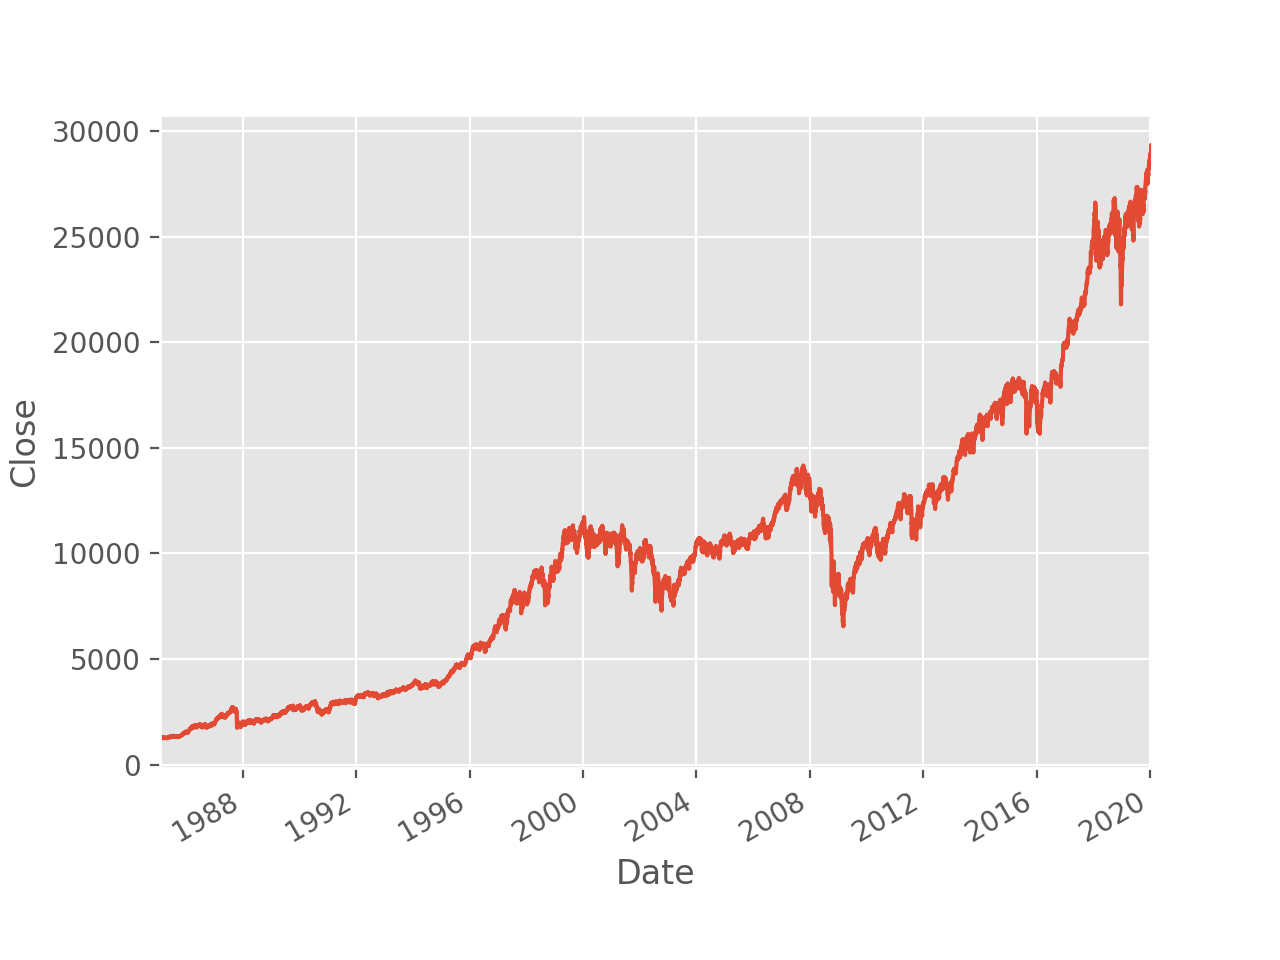

In [250]:
%matplotlib notebook
DJI["Close"].plot()
plt.ylabel("Close")
plt.show()
plt.savefig("DJI.png")

In [114]:
close=DJI["Close"]

In [224]:
train_size = int(len(close) * 0.90)
test_size = len(close) - train_size
train = pd.DataFrame(close.iloc[0:train_size])
test = pd.DataFrame(close.iloc[train_size:len(close)])
print(train.shape, test.shape)

(7938, 1) (882, 1)


In [225]:
from sklearn.preprocessing import StandardScaler

In [226]:
sc = StandardScaler().fit(train)

In [227]:
train["Close"]=sc.transform(train)

In [228]:
test["Close"]=sc.transform(test)

In [229]:
def create_dataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [230]:
time_steps = 30

X_train, y_train = create_dataset(train,train["Close"],time_steps)
X_test, y_test = create_dataset(test,test["Close"],time_steps)


In [231]:
X_train=X_train.reshape((7908, 30, 1))

In [16]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dropout

Using TensorFlow backend.


In [17]:
model = Sequential()
model.add(LSTM(units=128,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Train on 7117 samples, validate on 791 samples
Epoch 1/15
7117/7117 [==============================] - 20s 3ms/step - loss: 0.0418 - val_loss: 0.0292
Epoch 2/15
7117/7117 [==============================] - 19s 3ms/step - loss: 0.0027 - val_loss: 0.0062
Epoch 3/15
7117/7117 [==============================] - 20s 3ms/step - loss: 0.0019 - val_loss: 0.0035
Epoch 4/15
7117/7117 [==============================] - 20s 3ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 5/15
7117/7117 [==============================] - 20s 3ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 6/15
7117/7117 [==============================] - 20s 3ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 7/15
7117/7117 [==============================] - 20s 3ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 8/15
7117/7117 [==============================] - 20s 3ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 9/15
7117/7117 [==============================] - 20s 3ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 10/15
7117/7117 [===

In [28]:
y_pred_test= model.predict(X_test)

In [232]:
y_pred_train=model.predict(X_train)

<IPython.core.display.Javascript object>


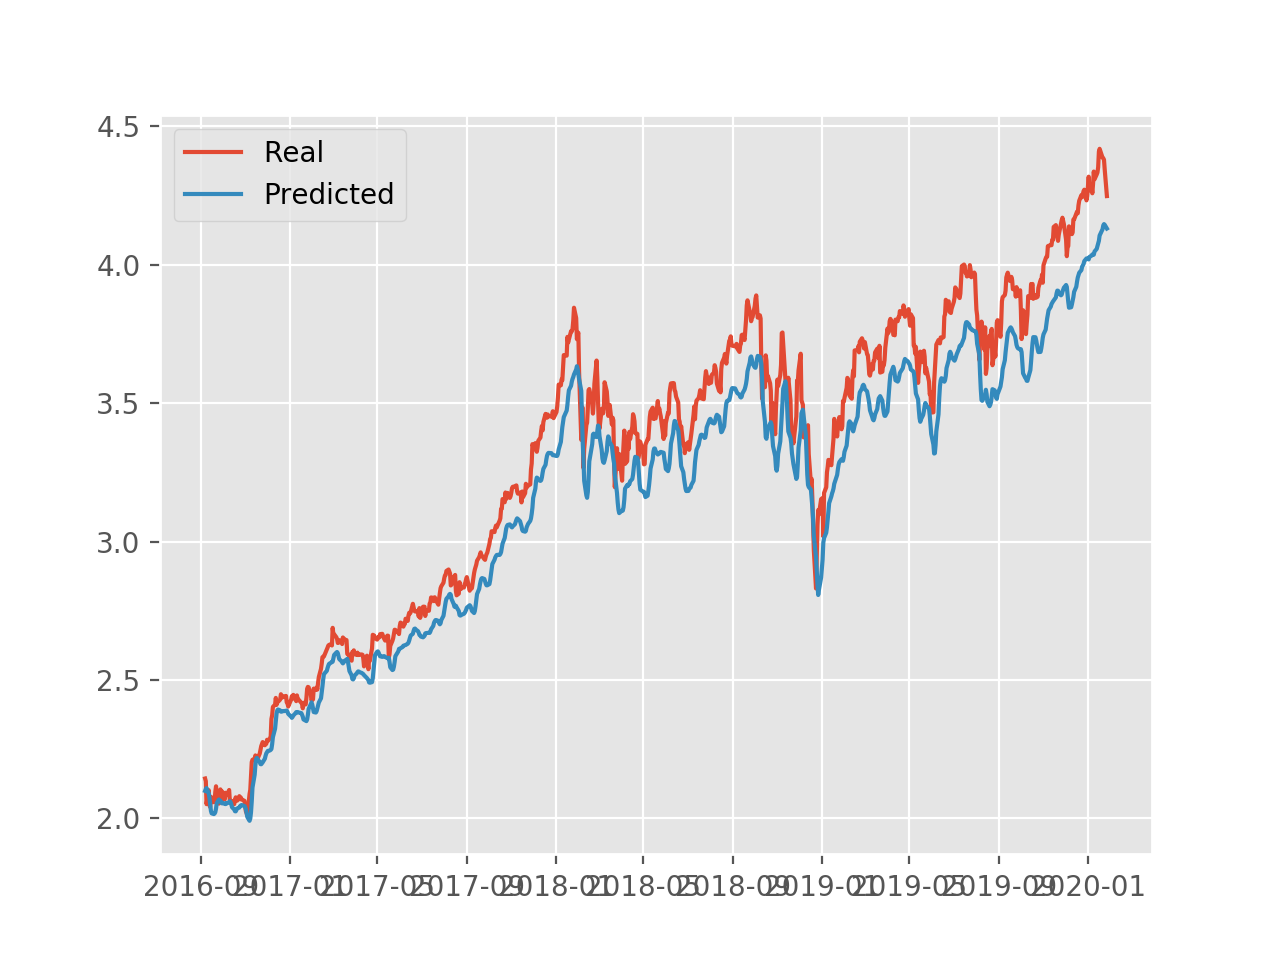

In [251]:
%matplotlib notebook
plt.plot(DJI.index[-852:],y_test,label= "Real")
plt.plot(DJI.index[-852:],y_pred_test,label= "Predicted")
plt.legend()
plt.show()
plt.savefig("ind.png")

<IPython.core.display.Javascript object>


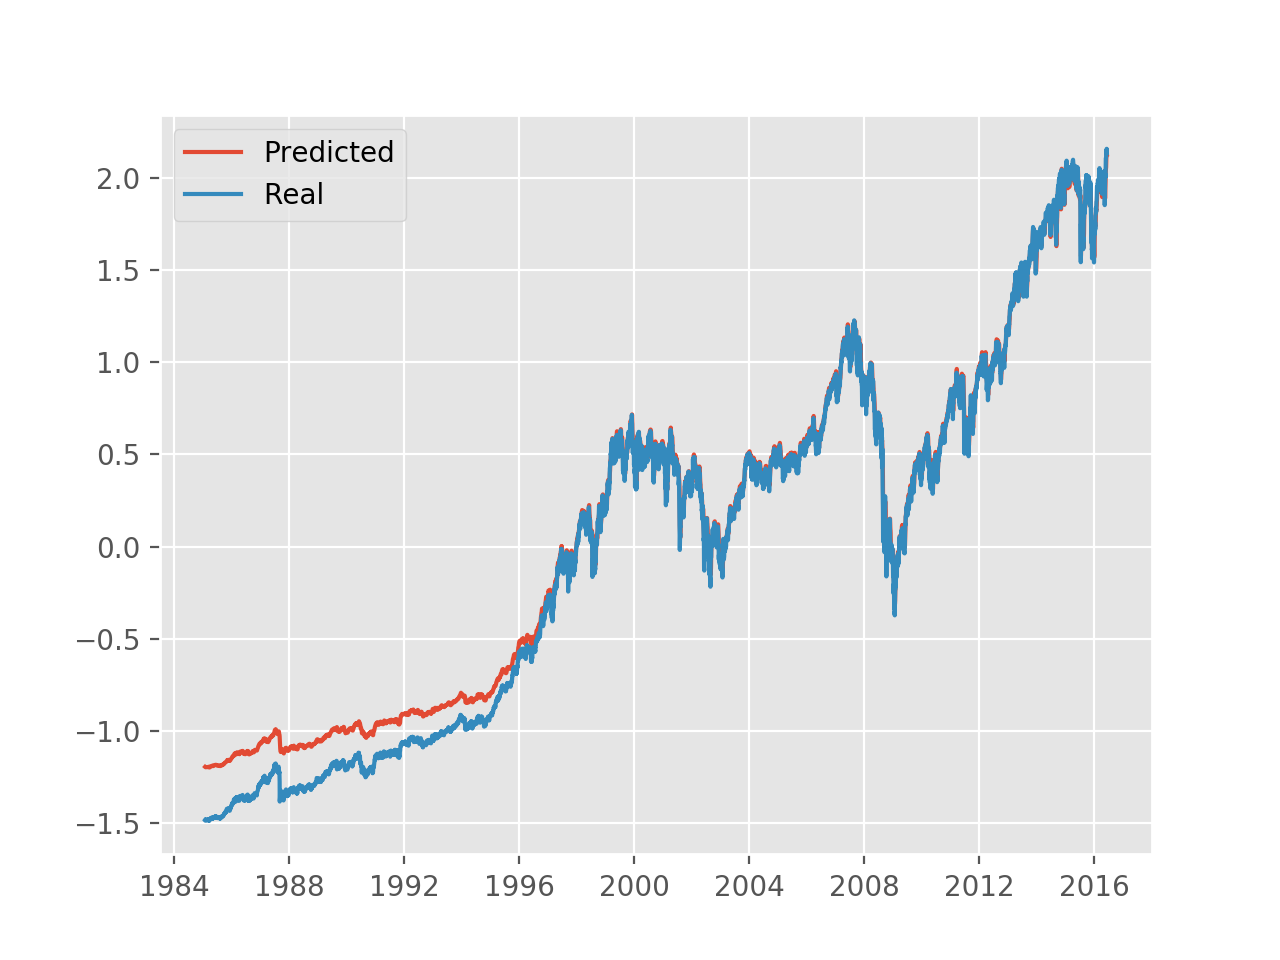

In [242]:
%matplotlib notebook
plt.plot(DJI.index[:7908],y_pred_train,label= "Predicted")
plt.plot(DJI.index[:7908],y_train,label= "Real")
plt.legend()
plt.show()

In [31]:
trainloss=np.mean(X_train, axis=1)-y_pred_train

In [32]:
testloss=np.mean(X_test, axis=1)-y_pred_test

In [43]:
trainloss=trainloss.reshape(7908,)

In [45]:
testloss=testloss.reshape(852,)

In [47]:
loss=np.append(trainloss,testloss)

<IPython.core.display.Javascript object>


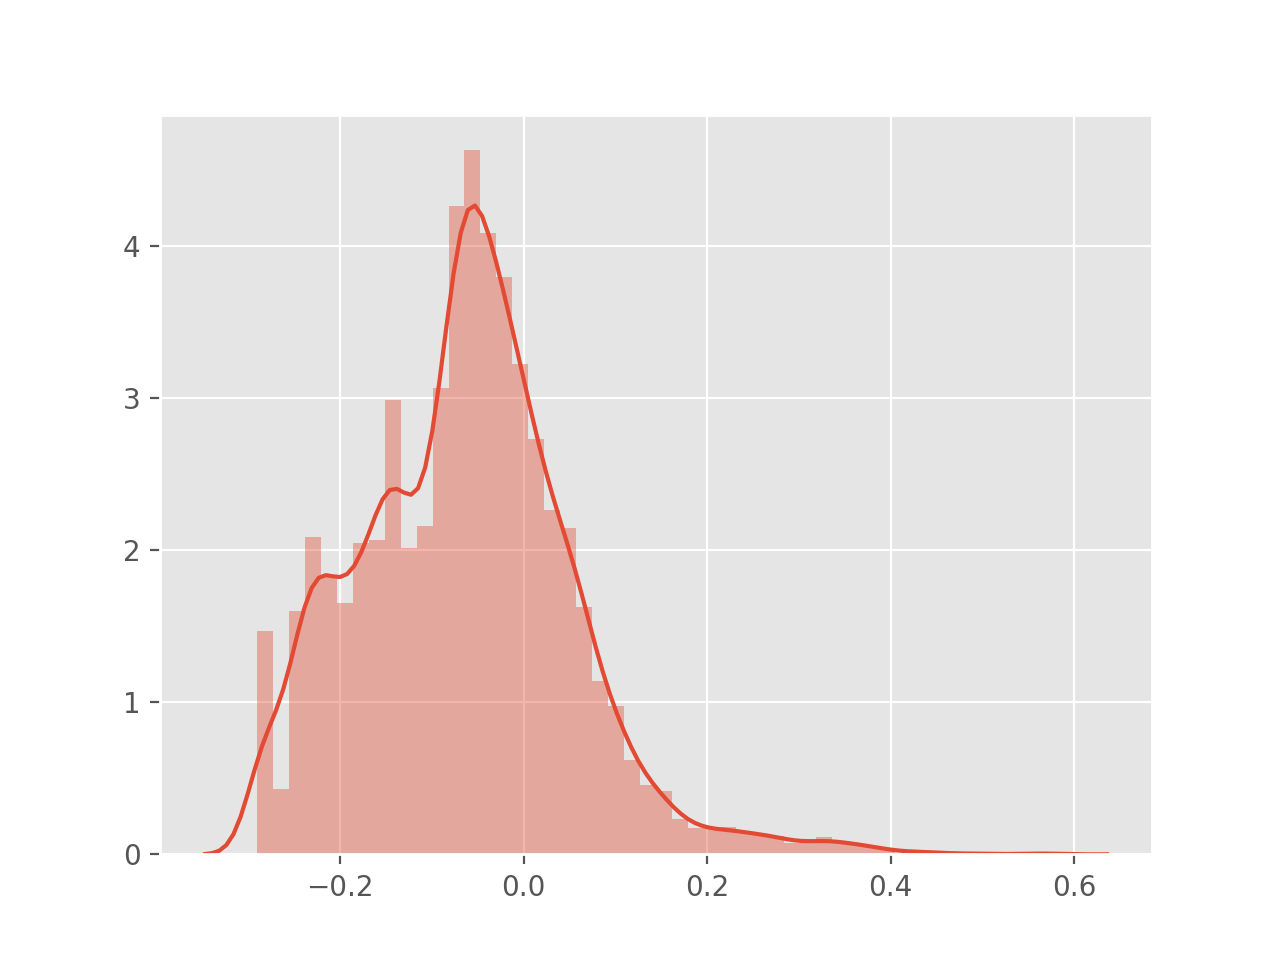

In [252]:
%matplotlib notebook
sns.distplot(loss)
plt.show()
plt.savefig("dist.png")

In [95]:
mu=np.mean(loss)

In [96]:
sigma=np.var(loss)

In [123]:
import scipy.stats as ss

In [255]:
test_score_df = pd.DataFrame(index=test[time_steps:].index)
test_score_df['loss'] = testloss
test_score_df['anomaly'] =abs(test_score_df.loss) > 0.3
test_score_df['close'] = test[time_steps:].Close
test_score_df["mahdist"]=(((test_score_df['loss']-mu)**2)/sigma)**(1/2)

In [256]:
ano=test_score_df[test_score_df['anomaly']==True]

<IPython.core.display.Javascript object>


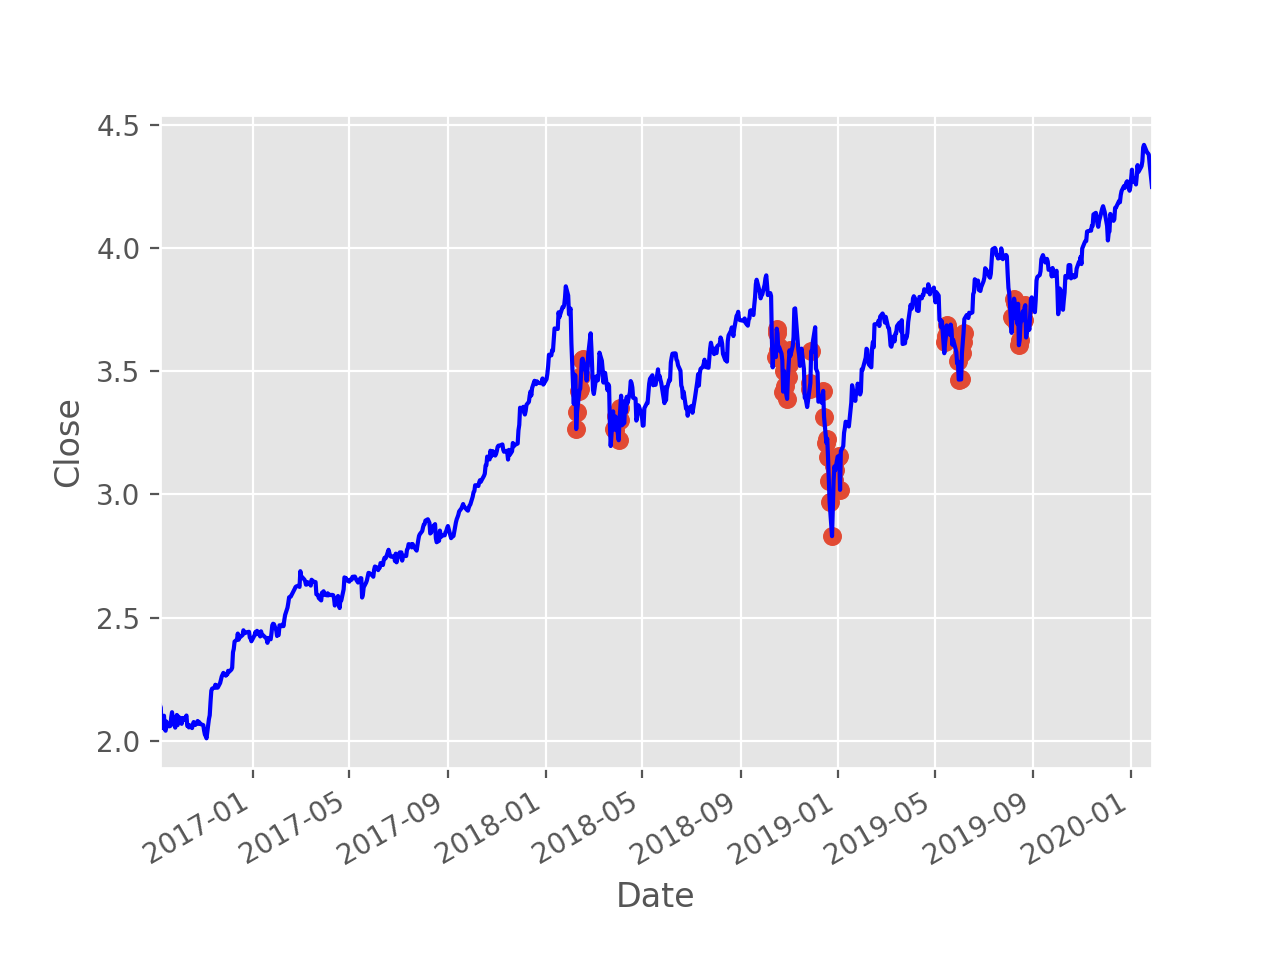

In [262]:
%matplotlib notebook
plt.scatter(ano.index,ano["close"],s=40)
test_score_df["close"].plot(c="blue")
plt.ylabel("Close")
plt.show()
plt.savefig("anom.png")

<IPython.core.display.Javascript object>


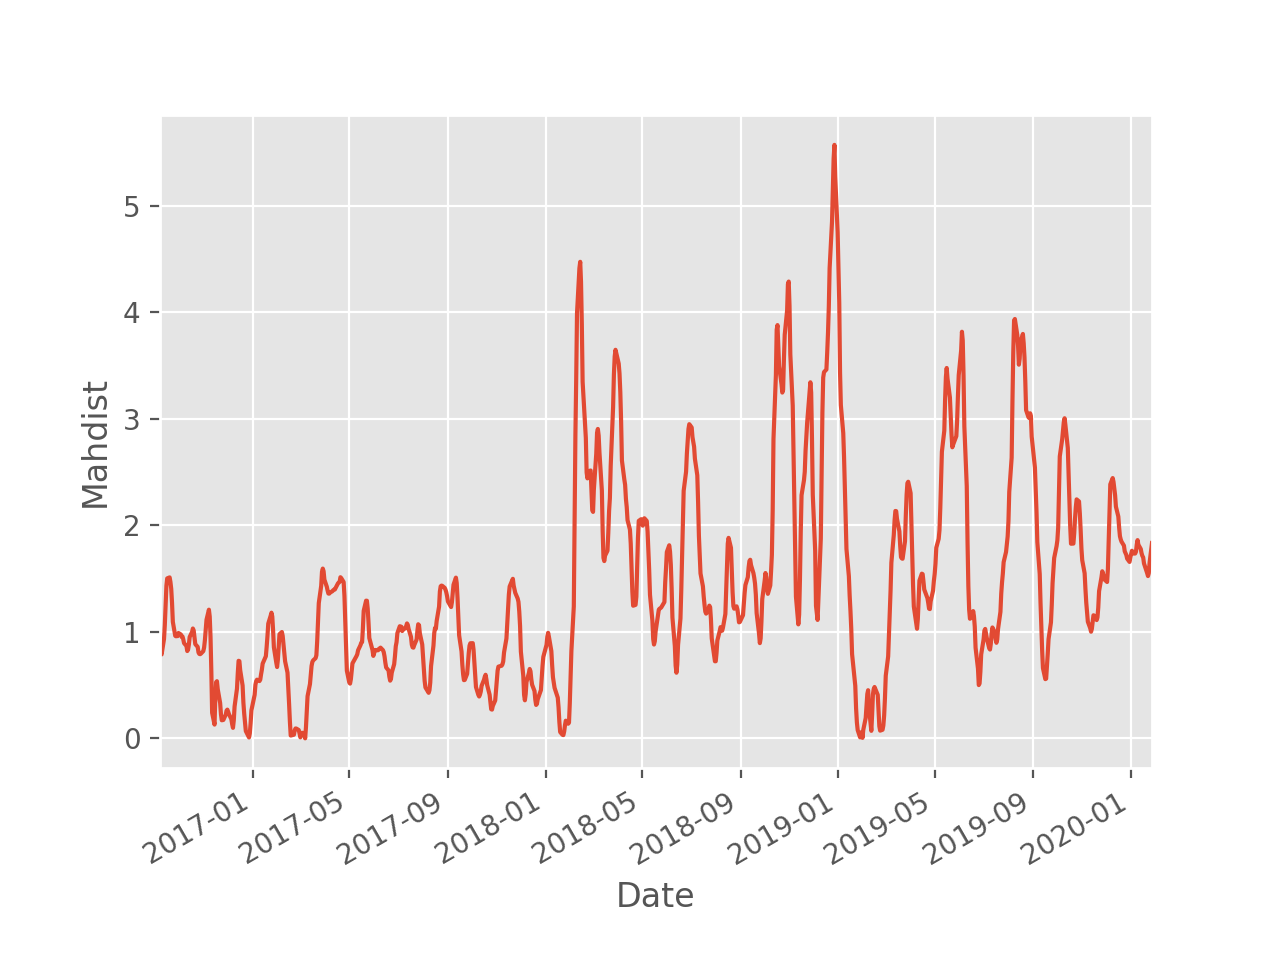

In [263]:
%matplotlib notebook
test_score_df["mahdist"].plot()
plt.ylabel("Mahdist")
plt.show()
plt.savefig("mah.png")

In [191]:
test_score_df['anomaly1'] =test_score_df.mahdist > 3

In [192]:
ano1=test_score_df[test_score_df['anomaly1']==True]

<IPython.core.display.Javascript object>


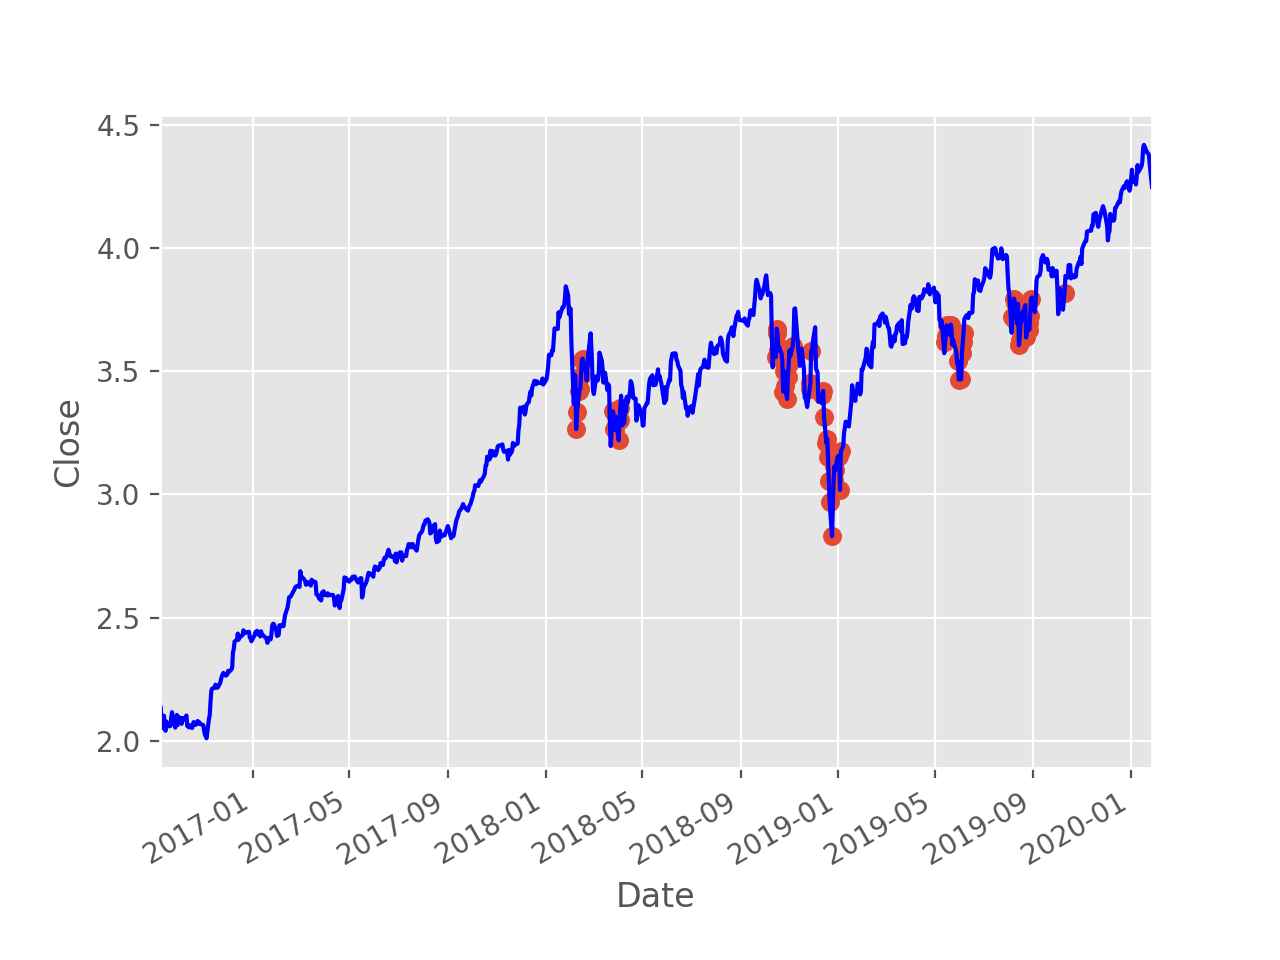

In [264]:
%matplotlib notebook
plt.scatter(ano1.index,ano1["close"],s=40)
test_score_df["close"].plot(c="blue")
plt.ylabel("Close")
plt.show()
plt.savefig("anomah.png")

In [195]:
from sklearn.metrics import mean_squared_error

In [196]:
mean_squared_error(np.mean(X_test, axis=1),y_pred_test)

0.024024945438004087